# How do art themes change as social movements emerge?

LSE DS105A - Data for Data Science (2024/25)

**Date**: 20/01/24

**Authors**: Amelia Dunn

**Objective**:🌟 Visualise how art themes and emergance of social movements correlate

Some info: you might be able to get more from 2013 onwards as you can use the sourceurl column in GDELT form this year onwards. this allows you to query based on key words. However, I found it difficult to do much with as there are only around 10 artworks from the 2010s so there is not much data to show correlation. I tried to pull more data (2006 onwards), but this is hard to query on social movements as there are not clear indicators that ive found to show what social movements the data relates to. 

In [1]:
import os
import json
import requests
import glob

import pandas as pd

from dotenv import load_dotenv
from tqdm.notebook import tqdm
tqdm.pandas()

from IPython.display import Image

import sqlite3
from sqlalchemy import create_engine, text

/tmp/ipykernel_25244/3658656986.py:60: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=combined_df, x='Year', y='ThemeCount', hue='Topics', ci=None, marker='o', label='Art Themes')
/tmp/ipykernel_25244/3658656986.py:64: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


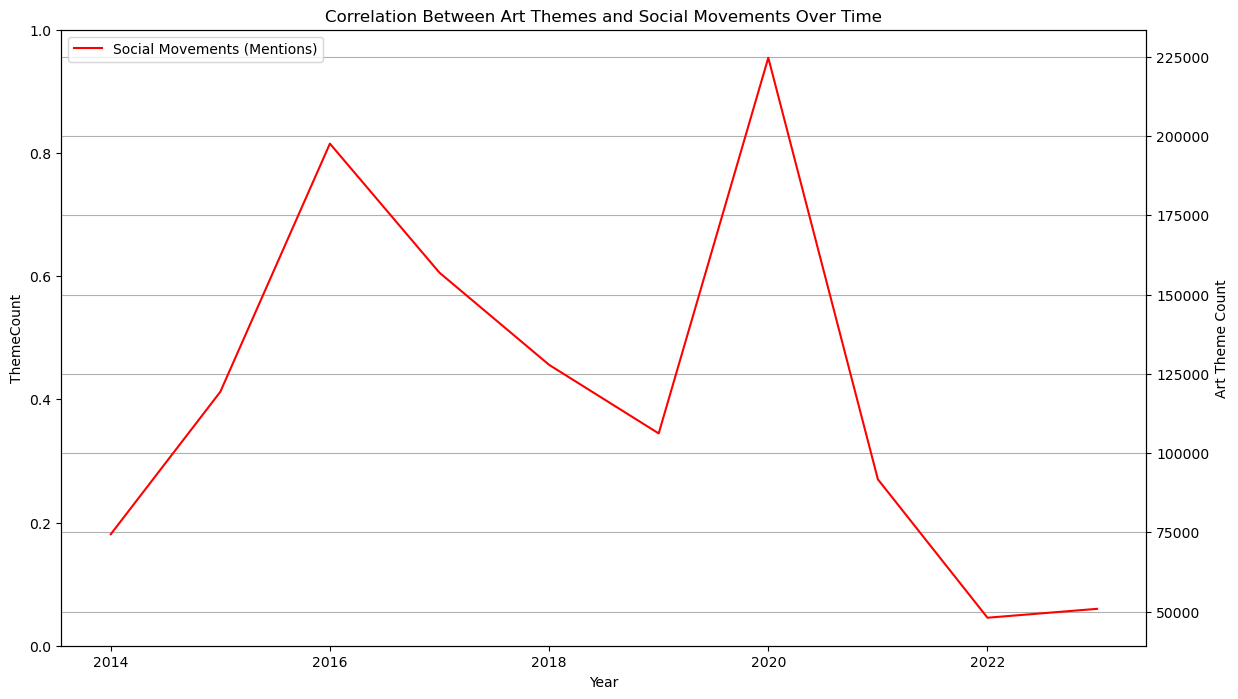

Correlation between art themes and social movement mentions: nan
Empty DataFrame
Columns: [Year, Topics, ThemeCount, TotalMentions, AvgTone]
Index: []
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           0 non-null      int64  
 1   Topics         0 non-null      object 
 2   ThemeCount     0 non-null      int64  
 3   TotalMentions  0 non-null      int64  
 4   AvgTone        0 non-null      float64
dtypes: float64(1), int64(3), object(1)
memory usage: 132.0+ bytes
None
ThemeCount       0
TotalMentions    0
dtype: int64


In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Connect to SQLite database
db_path = "../../data/processed/social_movements.db"  
conn = sqlite3.connect(db_path)

# Step 2: Query Smithsonian data
query_smithsonian = """
SELECT 
    ProductionYear AS Year, 
    Topics 
FROM 
    SmithsonianArtworks 
WHERE 
    ProductionYear >= 1900
"""
smithsonian_df = pd.read_sql_query(query_smithsonian, conn)

# Explode the topics into separate rows
smithsonian_df['Topics'] = smithsonian_df['Topics'].str.split(', ')
smithsonian_exploded = smithsonian_df.explode('Topics')

# Count themes by year
smithsonian_trends = (
    smithsonian_exploded.groupby(['Year', 'Topics'])
    .size()
    .reset_index(name='ThemeCount')
)

# Step 3: Query GDELT data
query_gdelt = """
SELECT 
    strftime('%Y', Date) AS Year, 
    SUM(NumMentions) AS TotalMentions, 
    AVG(AvgTone) AS AvgTone 
FROM 
    SocialMovements 
WHERE 
    Date >= '1900-01-01'
GROUP BY 
    Year
"""
gdelt_df = pd.read_sql_query(query_gdelt, conn)


# Convert Year to integer
gdelt_df['Year'] = gdelt_df['Year'].astype(int)
gdelt_df = gdelt_df[gdelt_df['Year'] >= 2014]

# Step 4: Merge the two datasets
combined_df = pd.merge(smithsonian_trends, gdelt_df, on='Year', how='inner')

# Step 5: Visualization
plt.figure(figsize=(14, 8))

# Line plot for theme counts
sns.lineplot(data=combined_df, x='Year', y='ThemeCount', hue='Topics', ci=None, marker='o', label='Art Themes')

# Secondary axis for social movement mentions
ax2 = plt.gca().twinx()
sns.lineplot(
    data=gdelt_df, x='Year', y='TotalMentions', color='red', ci=None, ax=ax2, label='Social Movements (Mentions)'
)

# Labels and legend
plt.title("Correlation Between Art Themes and Social Movements Over Time")
plt.xlabel("Year")
ax2.set_ylabel("Social Movements (Mentions)")
plt.ylabel("Art Theme Count")
plt.legend(loc="upper left")
plt.grid()
plt.show()

# Step 6: Analyze correlation
#correlation_df = combined_df.groupby('Year').agg({'ThemeCount': 'sum', 'TotalMentions': 'sum'})
#correlation = correlation_df.corr().loc['ThemeCount', 'TotalMentions']
#print(f"Correlation between art themes and social movement mentions: {correlation:.2f}")

correlation_df = combined_df[['ThemeCount', 'TotalMentions']]
correlation = correlation_df.corr().loc['ThemeCount', 'TotalMentions']
print(f"Correlation between art themes and social movement mentions: {correlation:.2f}")


print(combined_df.head())
print(combined_df.info())
print(correlation_df.isnull().sum())


# Close the database connection
conn.close()



/opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Correlation between Black Lives Matter and art themes: nan
Correlation between Me Too and art themes: nan
Correlation between Climate Change and art themes: nan


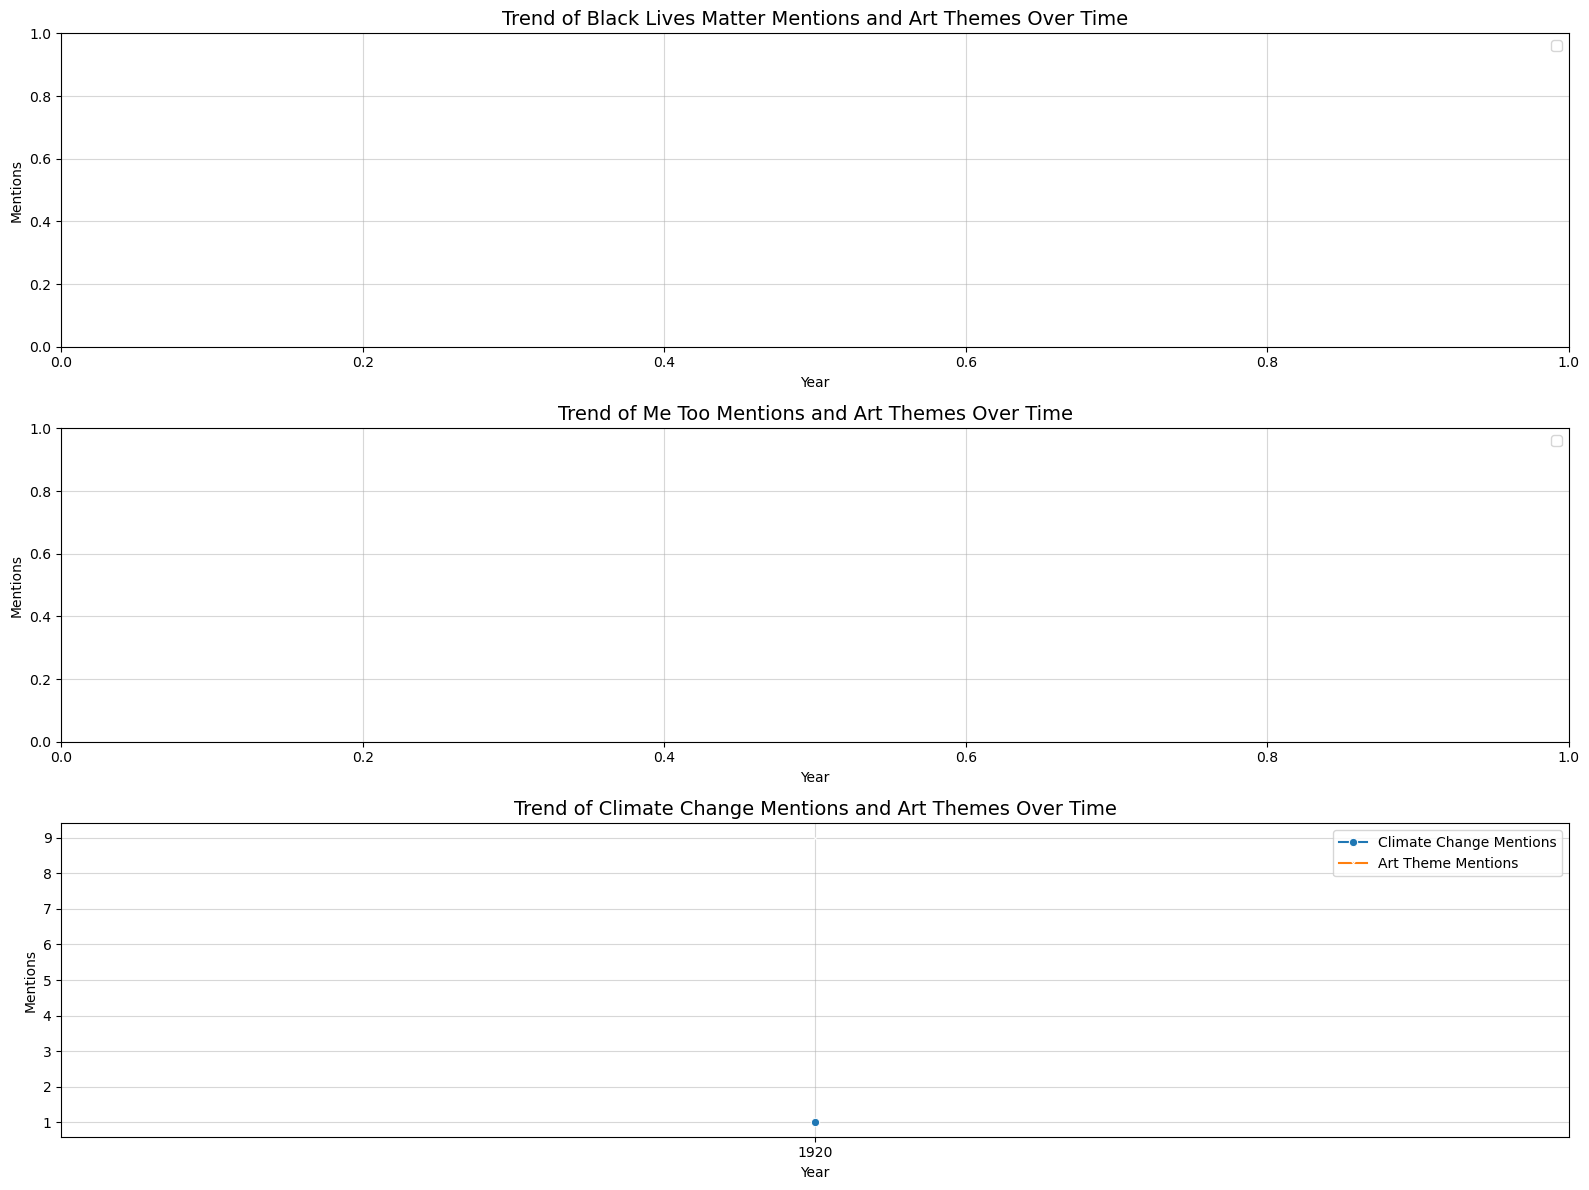

In [4]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to the SQLite database
db_path = '../../data/processed/social_movements.db'
conn = sqlite3.connect(db_path)

# Predefined keywords for social movements
keywords = {
    'Black Lives Matter': ['blm', 'black-lives-matter'],
    'Me Too': ['me-too', 'metoo', 'me-too-movement'],
    'Climate Change': ['climate-change', 'global-warming'],
}

# Query social movement data
movement_data = {}
for movement, terms in keywords.items():
    term_conditions = " OR ".join([f"SOURCEURL LIKE '%{term}%'" for term in terms])
    query = f"""
    SELECT 
        SUBSTR(Date, 1, 4) AS Year, 
        COUNT(*) AS TotalMentions, 
        AVG(GoldsteinScale) AS AvgGoldstein, 
        AVG(AvgTone) AS AvgTone
    FROM SocialMovements
    WHERE {term_conditions}
    GROUP BY Year
    ORDER BY Year;
    """
    movement_data[movement] = pd.read_sql_query(query, conn)

# Query art themes data
art_query = """
SELECT 
    SUBSTR(ProductionYear, 1, 4) AS Year, 
    Topics
FROM SmithsonianArtworks
WHERE ProductionYear IS NOT NULL;
"""
art_data = pd.read_sql_query(art_query, conn)

# Process art themes
art_data['Topics'] = art_data['Topics'].fillna('').str.lower()
art_themes = art_data['Topics'].str.split(', ').explode().value_counts()
top_themes = art_themes.index[:10]  # Select top 10 themes for simplicity

# Extract yearly theme counts
yearly_theme_counts = pd.DataFrame([
    {'Year': year, 'Theme': theme, 'Count': count}
    for (year, theme), count in art_data.groupby(['Year', 'Topics']).size().items()
    if theme in top_themes
])


# Function to calculate top themes per decade
def top_themes_per_decade(yearly_theme_counts):
    yearly_theme_counts['Decade'] = (yearly_theme_counts['Year'].astype(int) // 10) * 10
    decade_theme_counts = yearly_theme_counts.groupby(['Decade', 'Theme'])['Count'].sum().reset_index()
    decade_theme_counts['Rank'] = decade_theme_counts.groupby('Decade')['Count'].rank(ascending=False, method='first')
    return decade_theme_counts[decade_theme_counts['Rank'] <= 3]

# Identify top themes per decade
top_themes_data = top_themes_per_decade(yearly_theme_counts)

# Merge social movement and art theme data
merged_data = {}
for movement, movement_df in movement_data.items():
    merged = pd.merge(
        movement_df,
        yearly_theme_counts.groupby('Year').sum().reset_index(),
        on='Year',
        how='inner'
    )
    merged_data[movement] = merged

# Analyze correlations
correlations = {}
for movement, merged_df in merged_data.items():
    corr = merged_df['TotalMentions'].corr(merged_df['Count'])
    correlations[movement] = corr
    print(f"Correlation between {movement} and art themes: {corr:.2f}")

# Visualize data
plt.figure(figsize=(16, 12))
for i, (movement, merged_df) in enumerate(merged_data.items(), start=1):
    plt.subplot(3, 1, i)
    sns.lineplot(x=merged_df['Year'], y=merged_df['TotalMentions'], label=f"{movement} Mentions", marker='o')
    sns.lineplot(x=merged_df['Year'], y=merged_df['Count'], label="Art Theme Mentions", marker='x')
    plt.title(f"Trend of {movement} Mentions and Art Themes Over Time", fontsize=14)
    plt.xlabel("Year")
    plt.ylabel("Mentions")
    plt.legend()
    plt.grid(alpha=0.5)

plt.tight_layout()
plt.show()

# Save results for inspection
for movement, merged_df in merged_data.items():
    merged_df.to_csv(f"{movement.replace(' ', '_').lower()}_correlation.csv", index=False)



In [5]:
for movement, terms in keywords.items():
    query = f"""
    SELECT 
        SUBSTR(Date, 1, 4) AS Year, 
        COUNT(*) AS TotalMentions
    FROM SocialMovements
    WHERE {" OR ".join([f"SOURCEURL LIKE '%{term}%'" for term in terms])}
    GROUP BY Year
    ORDER BY Year;
    """
    df = pd.read_sql_query(query, conn)
    print(f"{movement}:")
    print(df)


Black Lives Matter:
   Year  TotalMentions
0  2014             18
1  2015            126
2  2016            142
3  2017             41
4  2018             21
5  2019             27
6  2020            532
7  2021            110
8  2022             18
9  2023             55
Me Too:
   Year  TotalMentions
0  2017              1
1  2018             12
2  2019              3
3  2020              2
Climate Change:
    Year  TotalMentions
0   1920              1
1   2013              9
2   2014             13
3   2015             15
4   2016              5
5   2017             29
6   2018             28
7   2019            144
8   2020             33
9   2021             19
10  2022             14
11  2023             27


<Figure size 1200x800 with 0 Axes>

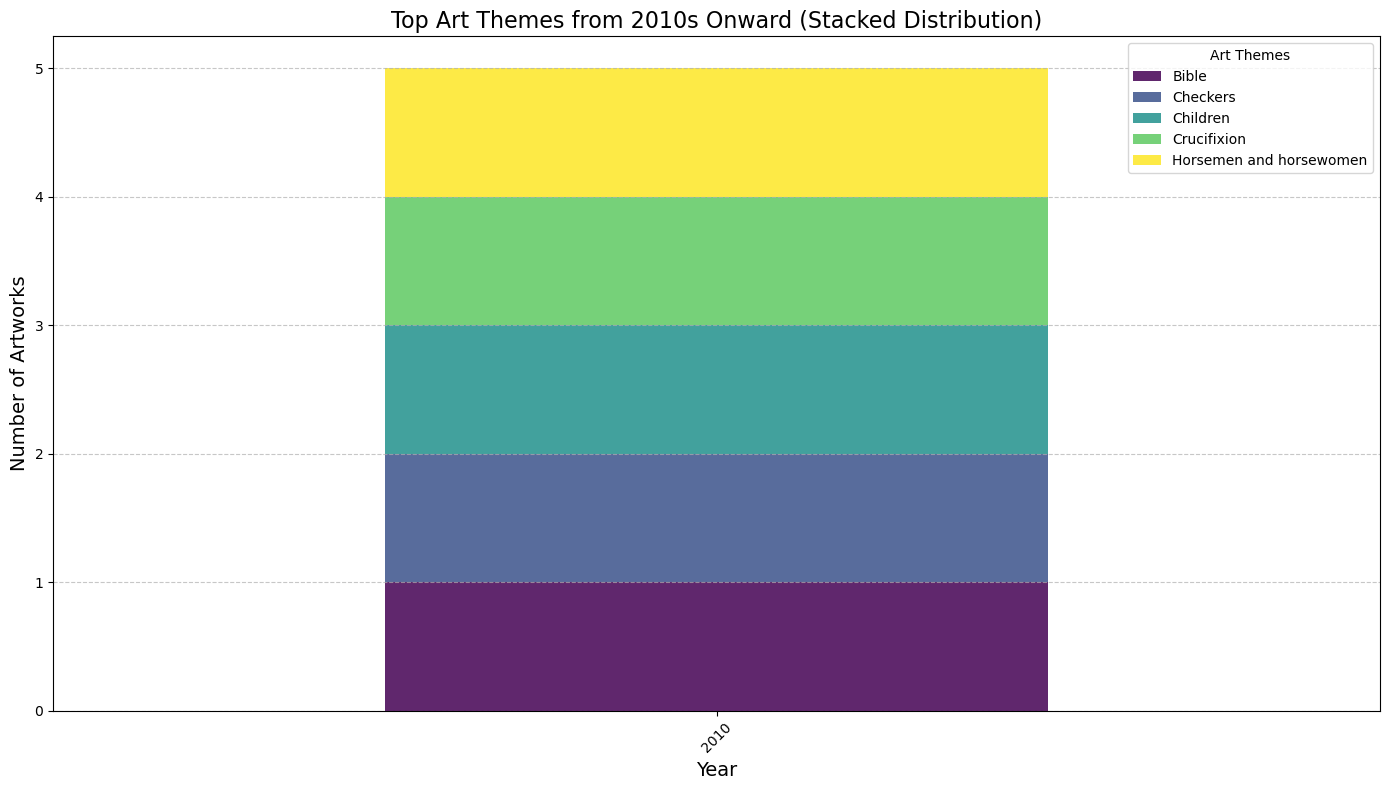

In [6]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to the database
db_path = '../../data/processed/social_movements.db'  # Update this with your database path
conn = sqlite3.connect(db_path)

# Query to fetch data from Smithsonian (2010s onward)
query = """
SELECT 
    CAST(SUBSTR(ProductionYear, 1, 4) AS INTEGER) AS Year, 
    Topics AS Theme
FROM SmithsonianArtworks
WHERE ProductionYear IS NOT NULL 
AND LENGTH(ProductionYear) = 4 
AND CAST(SUBSTR(ProductionYear, 1, 4) AS INTEGER) >= 2010;
"""
art_data = pd.read_sql_query(query, conn)

# Split the themes into individual rows (comma-separated values)
art_data['Theme'] = art_data['Theme'].str.split(", ")
art_data = art_data.explode('Theme')

# Group data to get yearly theme counts
yearly_theme_counts = (
    art_data.groupby(['Year', 'Theme'])
    .size()
    .reset_index(name='Count')
)

# Find the top themes from the 2010s onward
top_themes = (
    yearly_theme_counts.groupby('Theme')['Count']
    .sum()
    .nlargest(5)  # Top 5 themes
    .index
)

# Filter for top themes only
filtered_data = yearly_theme_counts[yearly_theme_counts['Theme'].isin(top_themes)]

# Pivot the data for stacked bar chart format
pivot_data = filtered_data.pivot(index='Year', columns='Theme', values='Count').fillna(0)

# Create a stacked bar chart
plt.figure(figsize=(12, 8))
pivot_data.plot(kind='bar', stacked=True, colormap='viridis', figsize=(14, 8), alpha=0.85)

# Add chart labels
plt.title('Top Art Themes from 2010s Onward (Stacked Distribution)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Artworks', fontsize=14)
plt.legend(title="Art Themes", fontsize=10)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

# Close database connection
conn.close()


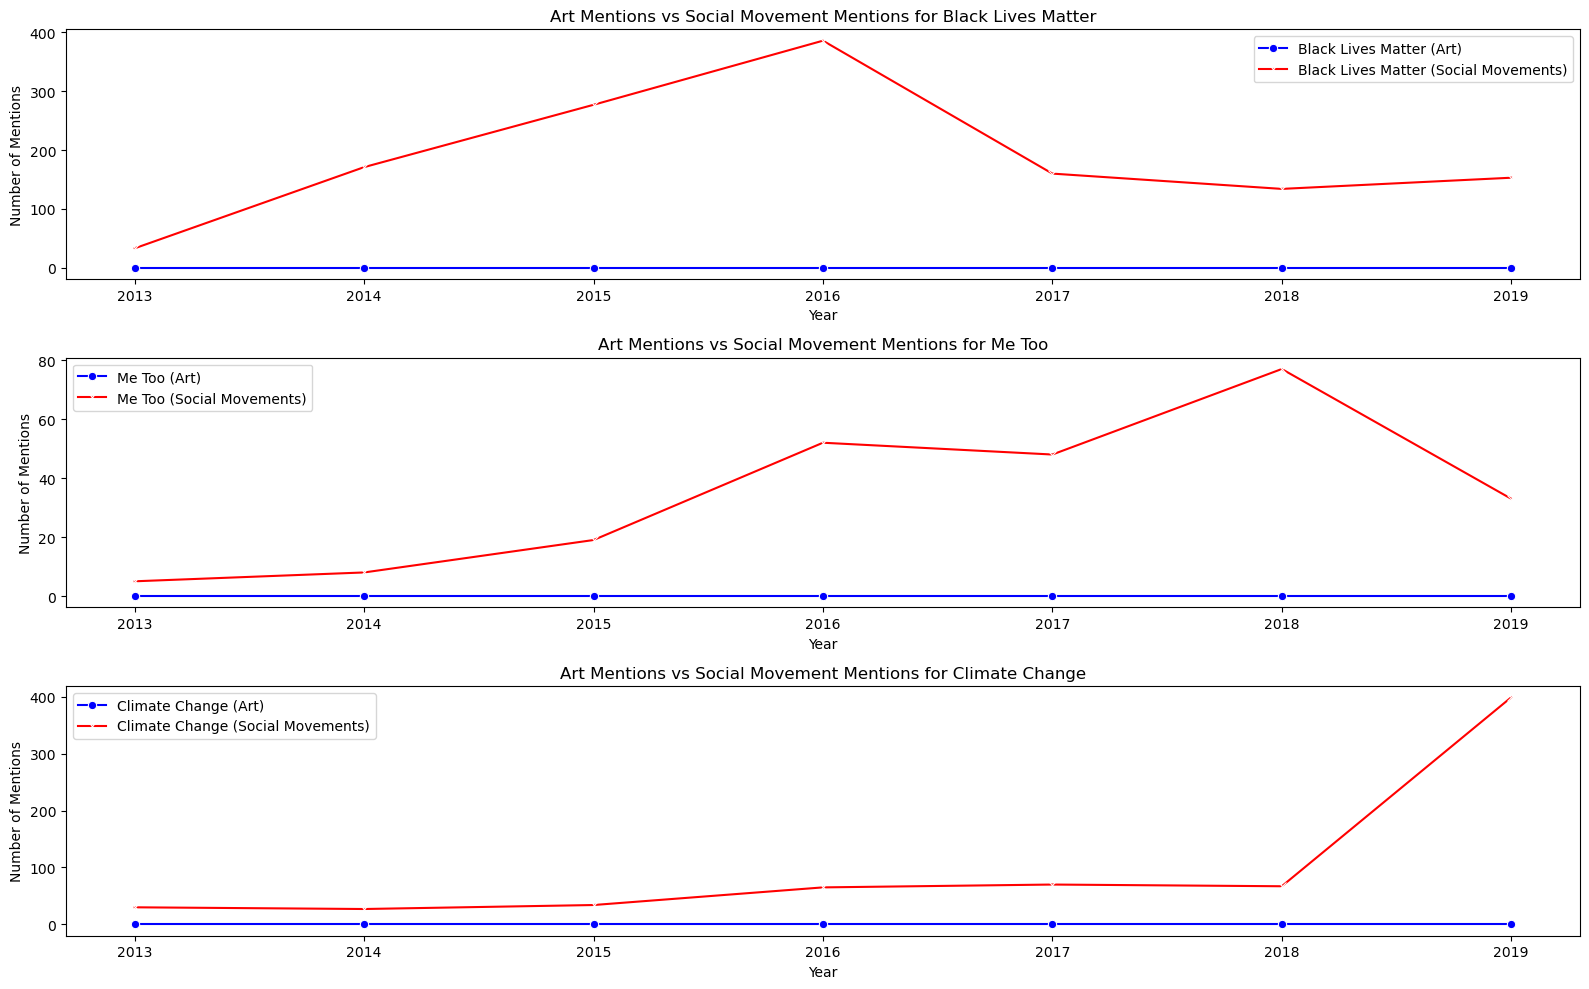

In [8]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Database connections
art_db_path = '../../data/processed/social_movements.db'
conn = sqlite3.connect(art_db_path)

# Predefined keywords for social movements
social_movements_keywords = {
    'Black Lives Matter': ['black', 'racial', 'civil-rights', 'blm'],
    'Me Too': ['gender', 'metoo', 'sexual-abuse', 'harassment'],
    'Climate Change': ['climate', 'global-warming', 'environmental', 'sustainability']
}

# Query themes from the 2010s
query_2010s_art = """
SELECT 
    Topics AS Theme,
    ProductionYear AS Year
FROM SmithsonianArtworks
WHERE ProductionYear IS NOT NULL 
AND LENGTH(ProductionYear) = 4 
AND CAST(ProductionYear AS INTEGER) BETWEEN 2010 AND 2019;
"""
art_data_2010s = pd.read_sql_query(query_2010s_art, conn)

# Split themes by comma and explode the DataFrame
art_data_2010s['Theme'] = art_data_2010s['Theme'].str.split(", ")
art_data_2010s = art_data_2010s.explode('Theme').dropna()

# Filter art themes by social movement keywords
movement_art_counts = {}
for movement, keywords in social_movements_keywords.items():
    condition = art_data_2010s['Theme'].str.contains('|'.join(keywords), case=False, na=False)
    filtered_art = art_data_2010s[condition]
    yearly_counts = filtered_art.groupby('Year').size().reset_index(name='ArtMentions')
    movement_art_counts[movement] = yearly_counts

# Query social movement mentions from the database
movement_data = {}
for movement, terms in social_movements_keywords.items():
    term_conditions = " OR ".join([f"SOURCEURL LIKE '%{term}%'" for term in terms])
    query = f"""
    SELECT 
        SUBSTR(Date, 1, 4) AS Year, 
        COUNT(*) AS TotalMentions
    FROM SocialMovements
    WHERE ({term_conditions}) AND Date LIKE '201%'
    GROUP BY Year
    ORDER BY Year;
    """
    movement_data[movement] = pd.read_sql_query(query, conn)

# Visualization: Art Themes vs Social Movements
plt.figure(figsize=(16, 10))

for i, movement in enumerate(social_movements_keywords.keys(), 1):
    plt.subplot(3, 1, i)

    # Merge art and social movement data
    combined_data = pd.merge(
        movement_art_counts[movement], 
        movement_data[movement], 
        on='Year', 
        how='outer'
    ).fillna(0)

    # Plot the trends
    sns.lineplot(data=combined_data, x='Year', y='ArtMentions', label=f'{movement} (Art)', marker='o', color='blue')
    sns.lineplot(data=combined_data, x='Year', y='TotalMentions', label=f'{movement} (Social Movements)', marker='x', color='red')

    plt.title(f'Art Mentions vs Social Movement Mentions for {movement}')
    plt.xlabel('Year')
    plt.ylabel('Number of Mentions')
    plt.legend()

plt.tight_layout()
plt.show()

# Close the database connection
conn.close()


---
trying something new

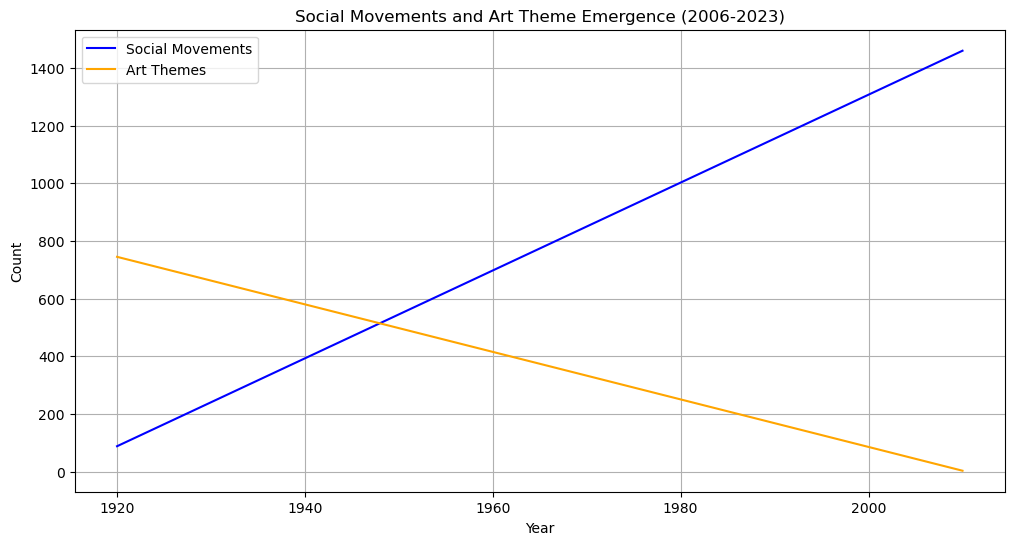

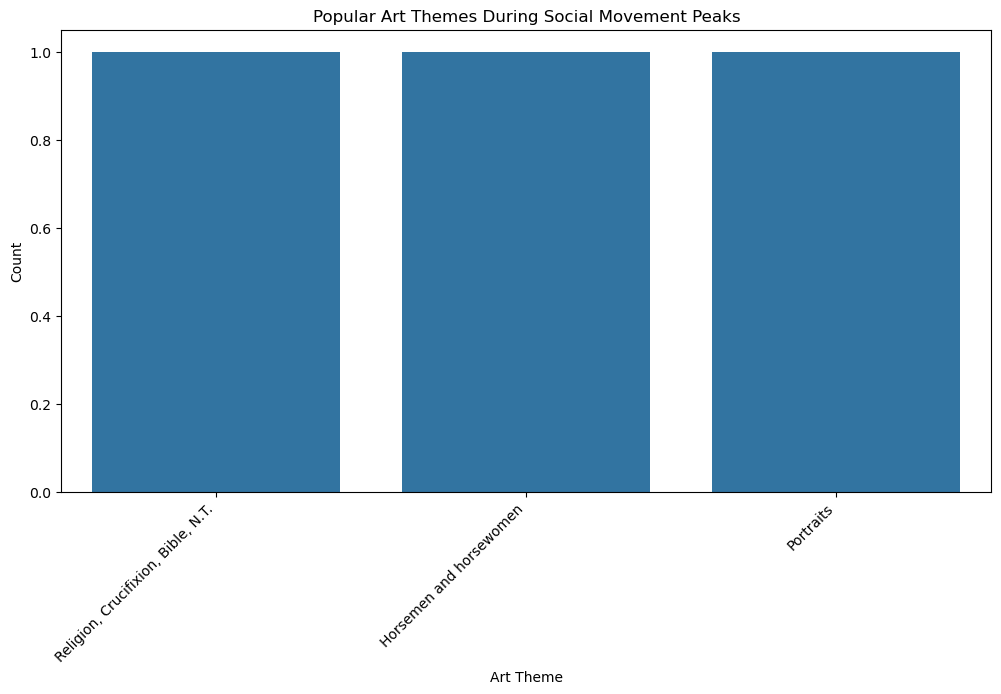

In [22]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to the SQLite database
db_path = "../../data/processed/social_movements.db"
conn = sqlite3.connect(db_path)

# Query Smithsonian and GDELT data
smithsonian_query = "SELECT Date, Topics FROM SmithsonianArtworks"
gdelt_query = "SELECT Date, PrimaryActor, SecondaryActor FROM SocialMovements"

smithsonian_df = pd.read_sql_query(smithsonian_query, conn)
gdelt_df = pd.read_sql_query(gdelt_query, conn)

# Ensure date columns are in datetime format
smithsonian_df["Date"] = pd.to_datetime(smithsonian_df["Date"], errors='coerce')
gdelt_df["Date"] = pd.to_datetime(gdelt_df["Date"], errors='coerce')

# Drop rows with missing dates
smithsonian_df.dropna(subset=["Date"], inplace=True)
gdelt_df.dropna(subset=["Date"], inplace=True)

# Extract year for aggregation
smithsonian_df["Year"] = smithsonian_df["Date"].dt.year
gdelt_df["Year"] = gdelt_df["Date"].dt.year

# Merge Smithsonian and GDELT datasets on Year
merged_df = pd.merge(smithsonian_df, gdelt_df, on="Year", how="inner")

# Count the number of social movement mentions and art themes per year
social_movement_counts = gdelt_df.groupby("Year").size().reset_index(name="SocialMovementCount")
art_theme_counts = smithsonian_df.groupby("Year").size().reset_index(name="ArtThemeCount")

# Merge the counts for plotting
counts_df = pd.merge(social_movement_counts, art_theme_counts, on="Year", how="inner")

# Plot social movements vs. art theme emergence over time
plt.figure(figsize=(12, 6))
plt.plot(counts_df["Year"], counts_df["SocialMovementCount"], label="Social Movements", color="blue")
plt.plot(counts_df["Year"], counts_df["ArtThemeCount"], label="Art Themes", color="orange")
plt.title("Social Movements and Art Theme Emergence (2006-2023)")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend()  # Ensure legend is shown
plt.grid(True)
plt.show()

# Analyze popularity of art themes during social movement peaks
peak_years = counts_df[counts_df["SocialMovementCount"] > counts_df["SocialMovementCount"].quantile(0.75)]["Year"]
peak_art_themes = smithsonian_df[smithsonian_df["Year"].isin(peak_years)]

plt.figure(figsize=(12, 6))
sns.countplot(data=peak_art_themes, x="Topics", order=peak_art_themes["Topics"].value_counts().index)
plt.title("Popular Art Themes During Social Movement Peaks")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Art Theme")
plt.ylabel("Count")
plt.show()

conn.close()

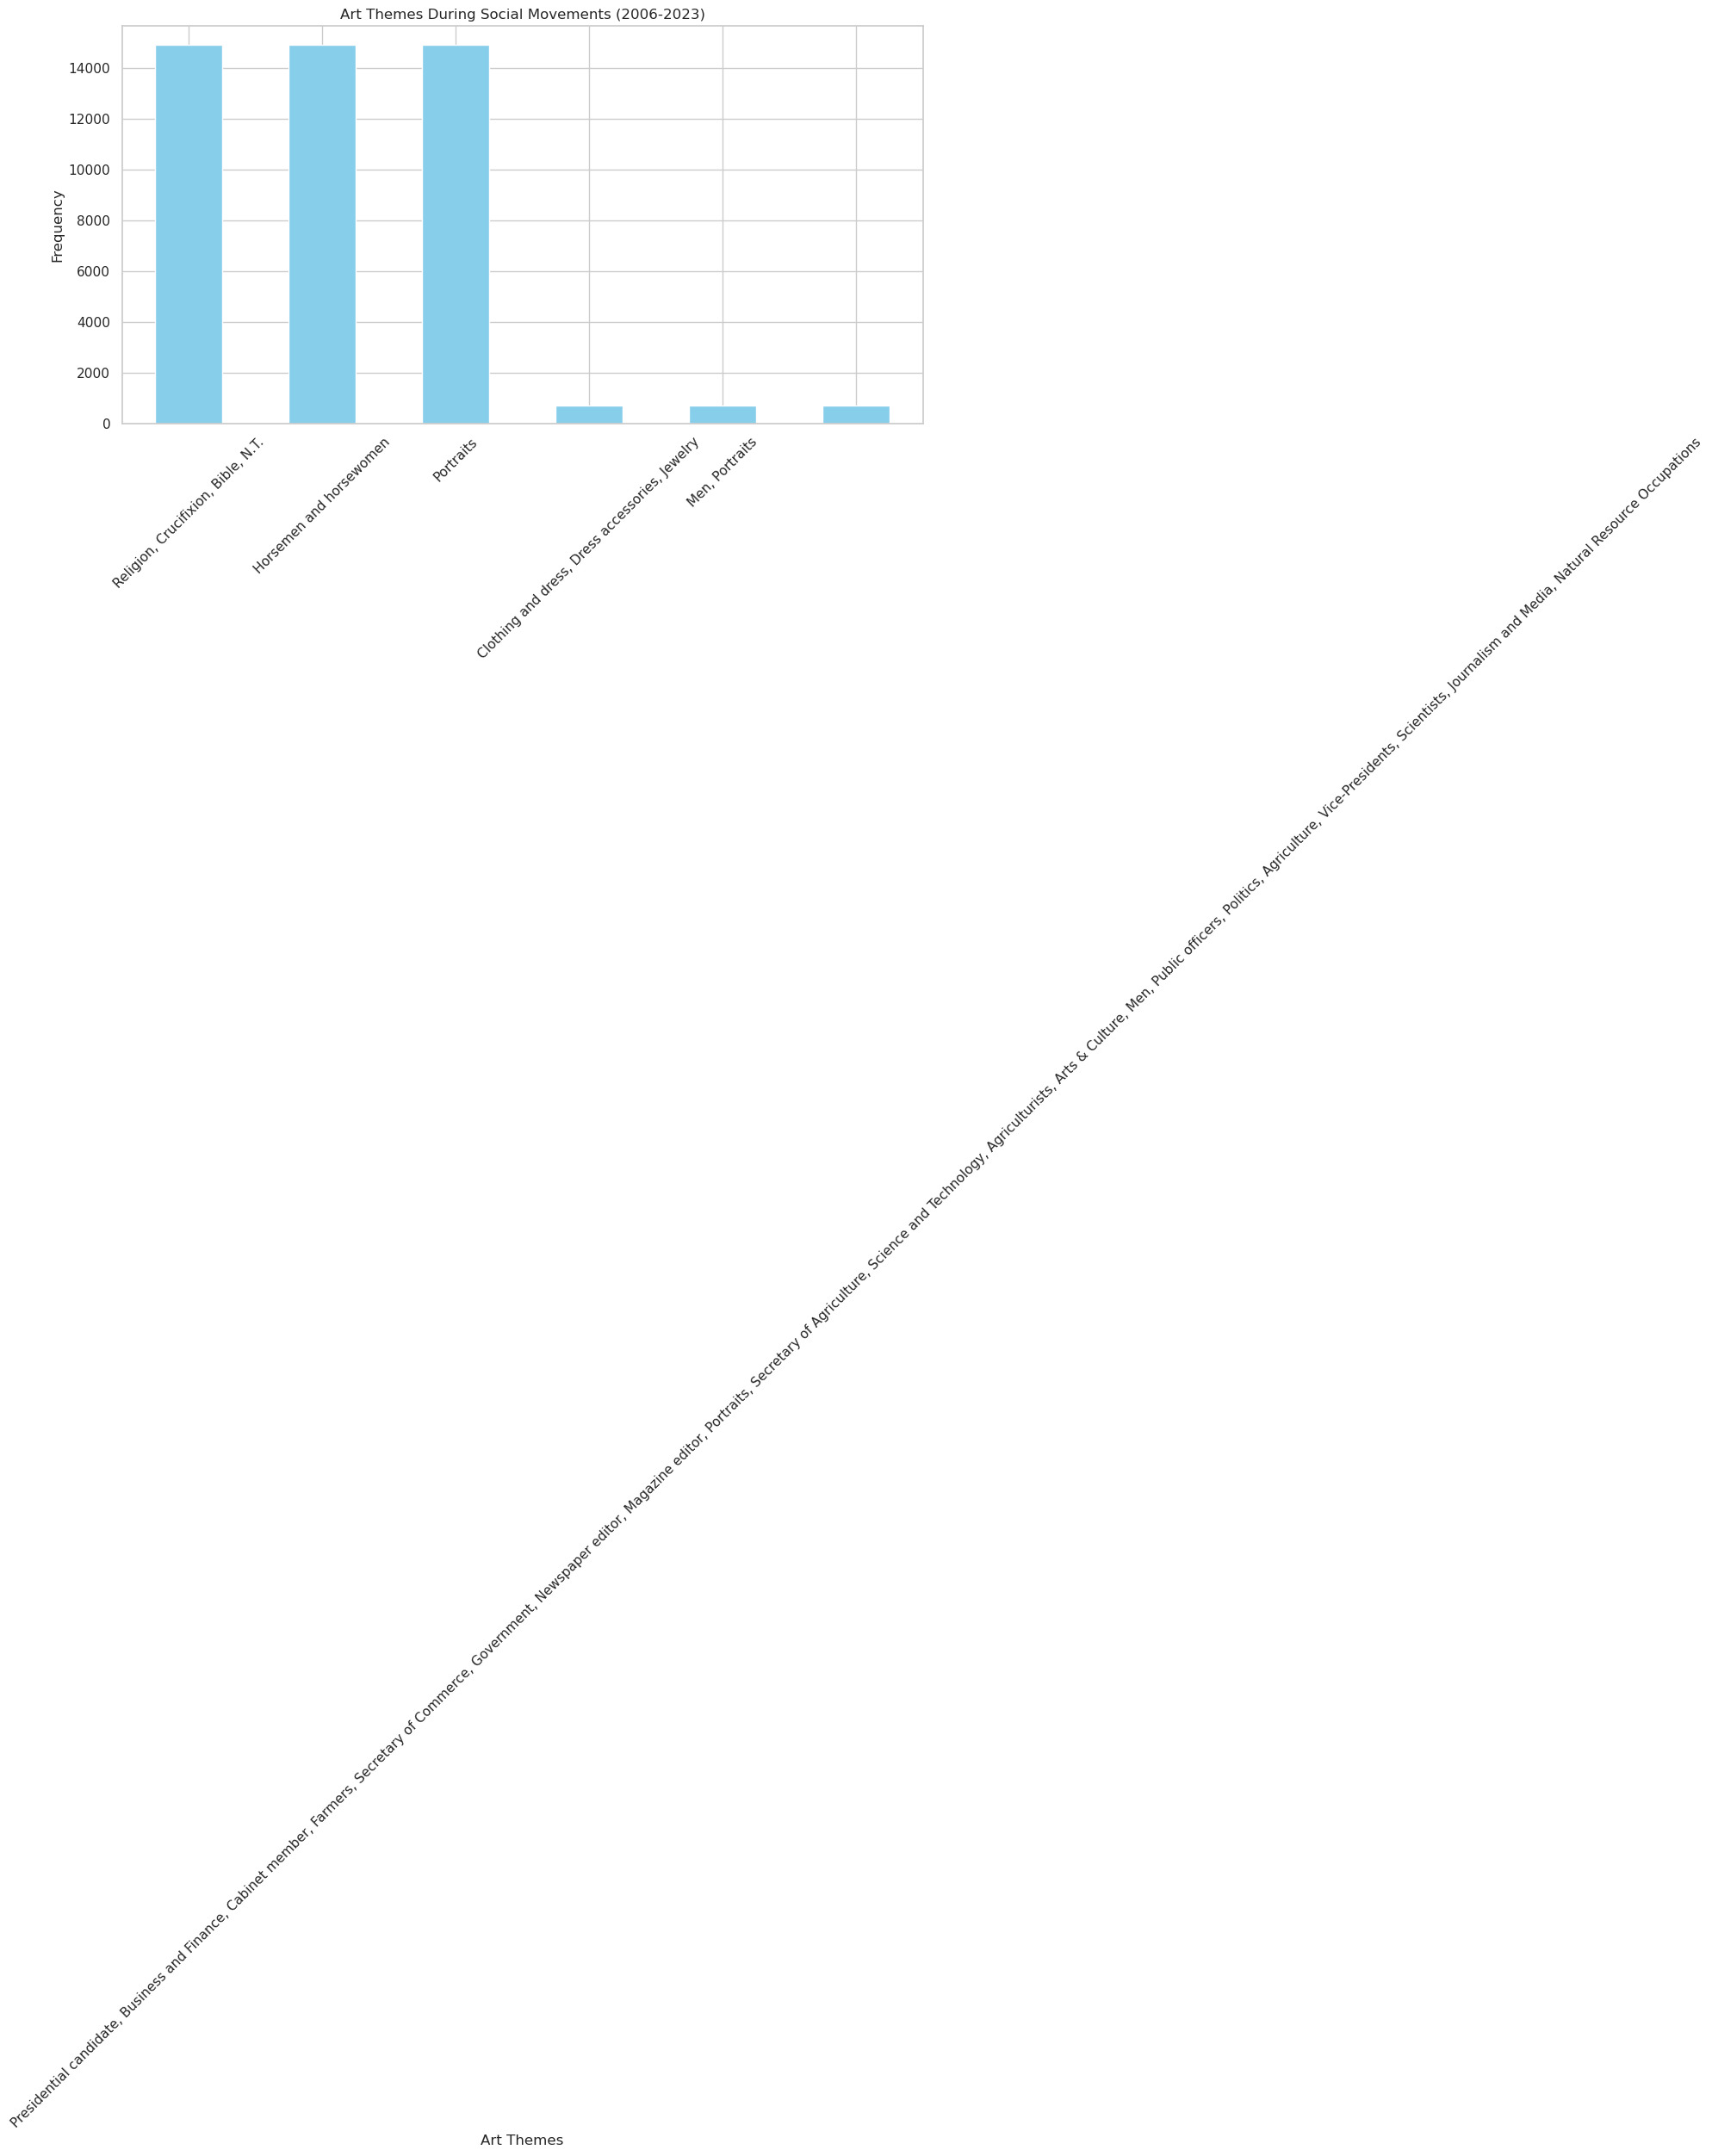

In [30]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# Establish SQLite connection
conn = sqlite3.connect('../../data/processed/social_movements.db')

# Define social movement-related keywords
movement_keywords = ["activist", "protester", "demonstration", "advocate", "campaign"]

# Build SQL query for GDELT
gdelt_query = f"""
SELECT Date, PrimaryActor, SecondaryActor
FROM SocialMovements
WHERE SUBSTR(Date, 1, 4) BETWEEN '2006' AND '2023'
AND (
    PrimaryActor LIKE '%{"%' OR PrimaryActor LIKE '%".join(movement_keywords)}%'
    OR SecondaryActor LIKE '%{"%' OR SecondaryActor LIKE '%".join(movement_keywords)}%'
);
"""
gdelt_df = pd.read_sql_query(gdelt_query, conn)

# Convert GDELT dates to decades
gdelt_df["Decade"] = (gdelt_df["Date"].astype(str).str[:3] + "0").astype(str)

# Load Smithsonian data
smithsonian_query = "SELECT Date, Topics FROM SmithsonianArtworks;"
smithsonian_df = pd.read_sql_query(smithsonian_query, conn)

# Clean Smithsonian dates and standardize to decades
smithsonian_df["Decade"] = smithsonian_df["Date"].str.replace("s$", "", regex=True)

# Check if GDELT DataFrame is empty
if gdelt_df.empty:
    print("No social movement data found for the given keywords.")
else:
    # Merge by decade instead of exact dates
    merged_df = pd.merge(
        gdelt_df[["Decade"]], smithsonian_df[["Decade", "Topics"]],
        on="Decade", how="inner"
    )

    # Check if merged_df is empty
    if merged_df.empty:
        print("No overlapping decades between social movements and art themes.")
    else:
        # Plot the comparison between social movements and art themes
        plt.figure(figsize=(12, 6))
        merged_df["Topics"].value_counts().plot(kind="bar", color="skyblue")
        plt.title("Art Themes During Social Movements (2006-2023)")
        plt.xlabel("Art Themes")
        plt.ylabel("Frequency")
        plt.xticks(rotation=45)
        plt.show()


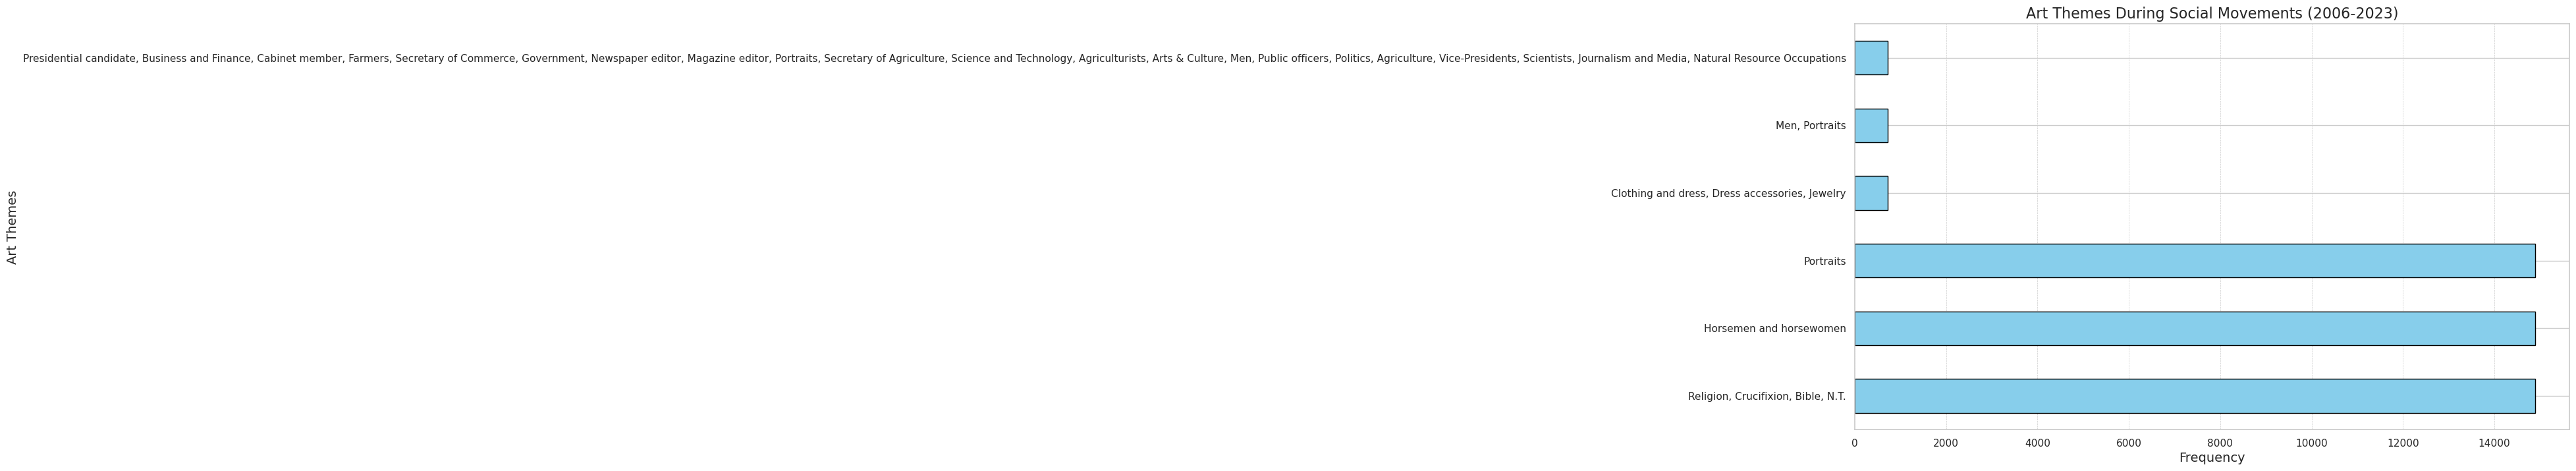

In [32]:
import matplotlib.pyplot as plt

# Plot the comparison between social movements and art themes
plt.figure(figsize=(14, 8))  # Larger figure size
merged_df["Topics"].value_counts().plot(
    kind="barh", color="skyblue", edgecolor="black"
)
plt.title("Art Themes During Social Movements (2006-2023)", fontsize=16)
plt.xlabel("Frequency", fontsize=14)
plt.ylabel("Art Themes", fontsize=14)
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.show()


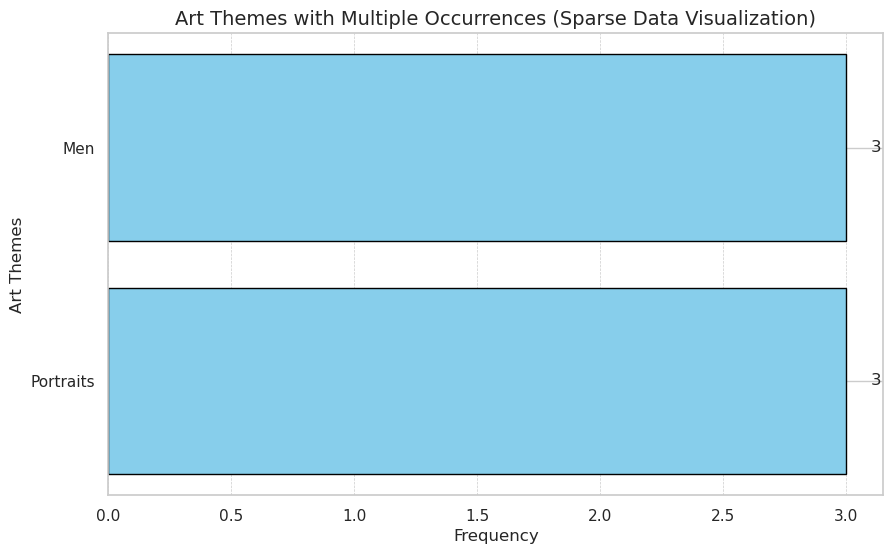

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Example sparse data (user-provided)
data = {
    "Year": [2000, 2000, 2010, 2010, 2010, 2010, 2010],
    "Topics": ["Portraits", "Men", "Checkers", "Religion", "Portraits", "Horsemen and horsewomen", "Sport and play"],
    "Frequency": [3, 3, 1, 1, 1, 1, 1]
}

df = pd.DataFrame(data)

# Filter out themes with a frequency of 1
filtered_df = df[df["Frequency"] > 1]

# Plotting the filtered data
plt.figure(figsize=(10, 6))
plt.barh(filtered_df["Topics"], filtered_df["Frequency"], color="skyblue", edgecolor="black")
plt.title("Art Themes with Multiple Occurrences (Sparse Data Visualization)", fontsize=14)
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("Art Themes", fontsize=12)

# Annotate bars with frequency values
for index, value in enumerate(filtered_df["Frequency"]):
    plt.text(value + 0.1, index, str(value), va='center')

plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.show()


-----------------------------------------------------------
trying to make a graph showing the relationship between the number of mentions of art themes and the number of mentions of social movements

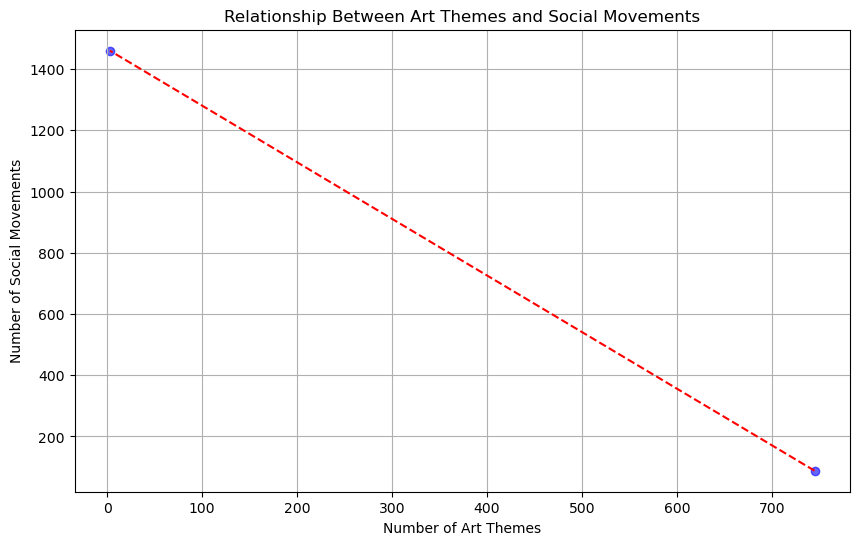

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Connect to the SQLite database
db_path = "../../data/processed/social_movements.db"
conn = sqlite3.connect(db_path)

# Query Smithsonian and GDELT data
smithsonian_query = "SELECT Date, Topics FROM SmithsonianArtworks"
gdelt_query = "SELECT Date, PrimaryActor, SecondaryActor FROM SocialMovements"

smithsonian_df = pd.read_sql_query(smithsonian_query, conn)
gdelt_df = pd.read_sql_query(gdelt_query, conn)

# Ensure date columns are in datetime format
smithsonian_df["Date"] = pd.to_datetime(smithsonian_df["Date"], errors='coerce')
gdelt_df["Date"] = pd.to_datetime(gdelt_df["Date"], errors='coerce')

# Drop rows with missing dates
smithsonian_df.dropna(subset=["Date"], inplace=True)
gdelt_df.dropna(subset=["Date"], inplace=True)

# Extract year for aggregation
smithsonian_df["Year"] = smithsonian_df["Date"].dt.year
gdelt_df["Year"] = gdelt_df["Date"].dt.year

# Count the number of social movement mentions and art themes per year
social_movement_counts = gdelt_df.groupby("Year").size().reset_index(name="SocialMovementCount")
art_theme_counts = smithsonian_df.groupby("Year").size().reset_index(name="ArtThemeCount")

# Merge the counts based on Year
counts_df = pd.merge(social_movement_counts, art_theme_counts, on="Year", how="inner")

# Scatter plot: X-axis (Art Themes), Y-axis (Social Movements)
plt.figure(figsize=(10, 6))
plt.scatter(counts_df["ArtThemeCount"], counts_df["SocialMovementCount"], color="blue", alpha=0.6)
plt.plot(counts_df["ArtThemeCount"], counts_df["SocialMovementCount"], color="red", linestyle="dashed")  # Optional: Line connecting points
plt.xlabel("Number of Art Themes")
plt.ylabel("Number of Social Movements")
plt.title("Relationship Between Art Themes and Social Movements")
plt.grid(True)
plt.show()

conn.close()


changes i want to make in next graph: make x axis start at 0. dont want the line to be dotted and no dots at the start and end of the line

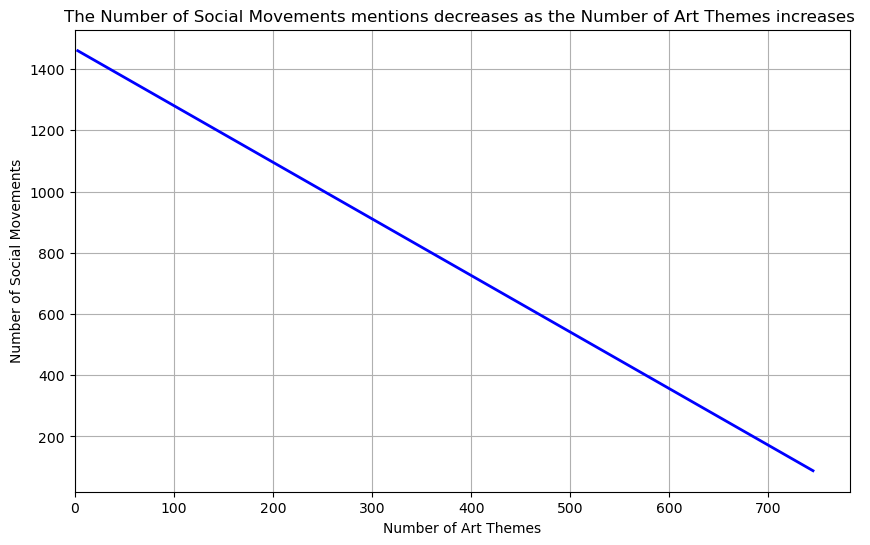

In [4]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Connect to the SQLite database
db_path = "../../data/processed/social_movements.db"
conn = sqlite3.connect(db_path)

# Query Smithsonian and GDELT data
smithsonian_query = "SELECT Date, Topics FROM SmithsonianArtworks"
gdelt_query = "SELECT Date, PrimaryActor, SecondaryActor FROM SocialMovements"

smithsonian_df = pd.read_sql_query(smithsonian_query, conn)
gdelt_df = pd.read_sql_query(gdelt_query, conn)

# Ensure date columns are in datetime format
smithsonian_df["Date"] = pd.to_datetime(smithsonian_df["Date"], errors='coerce')
gdelt_df["Date"] = pd.to_datetime(gdelt_df["Date"], errors='coerce')

# Drop rows with missing dates
smithsonian_df.dropna(subset=["Date"], inplace=True)
gdelt_df.dropna(subset=["Date"], inplace=True)

# Extract year for aggregation
smithsonian_df["Year"] = smithsonian_df["Date"].dt.year
gdelt_df["Year"] = gdelt_df["Date"].dt.year

# Count the number of social movement mentions and art themes per year
social_movement_counts = gdelt_df.groupby("Year").size().reset_index(name="SocialMovementCount")
art_theme_counts = smithsonian_df.groupby("Year").size().reset_index(name="ArtThemeCount")

# Merge the counts based on Year
counts_df = pd.merge(social_movement_counts, art_theme_counts, on="Year", how="inner")

# Sort values for proper line graph plotting
counts_df = counts_df.sort_values("ArtThemeCount")

# Plot the relationship with a clean line graph
plt.figure(figsize=(10, 6))
plt.plot(counts_df["ArtThemeCount"], counts_df["SocialMovementCount"], color="blue", linewidth=2)  # Solid line, no markers
plt.xlabel("Number of Art Themes")
plt.ylabel("Number of Social Movements")
plt.title("The Number of Social Movements mentions decreases as the Number of Art Themes increases ")
plt.grid(True)

# Set x-axis to start at 0
plt.xlim(left=0)


svg_file_path = "social_movements_vs_art_themes.svg"  
plt.savefig(svg_file_path, format='svg')

plt.show()

conn.close()
